In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import examples as eg
import numpy as np
from numpy import *
import dionysus

The circular coordinates pipeline for examining different smoothness cost-functions:

    Step 1. Getting the point cloud
    Step 2. Computing the Vietoris-Rips filtration and its cohomology
    Step 3. Selecting the Cocycle
    Step 4. First smoothing using Least Squares (Optional)
    Step 5. Second smoothing using a new cost function

## Step 1 - Getting the point cloud

In [3]:
annulus = eg.pinched_torus_example(n=200)
#The examples.py generates data points in form of point clouds that can be analyzed using the imported dionysus module.

## Step 2 - Computing Vietoris-Rips Complexes and Cohomology

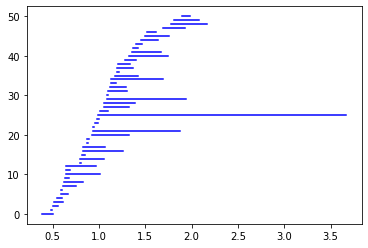

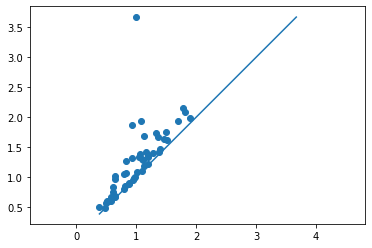

In [4]:
prime = 23 #choose the prime base for the coefficient field that we use to construct the persistence cohomology.

vr = dionysus.fill_rips(annulus, 2, 4.) #Vietoris-Rips complex
cp = dionysus.cohomology_persistence(vr, prime, True) #Create the persistent cohomology based on the chosen parameters.
dgms = dionysus.init_diagrams(cp, vr) #Calculate the persistent diagram using the designated coefficient field and complex.
dionysus.plot.plot_bars(dgms[1], show=True) 
dionysus.plot.plot_diagram(dgms[1], show=True) 
#dionysus.plot.plot_diagram(dgms[0], show=True) 
#Plot the barcode and diagrams using matplotlib incarnation within Dionysus2. This mechanism is different in Dionysus.

## Step 3 - Selecting the cocycle and visualization.

In [5]:
type(plt)

module

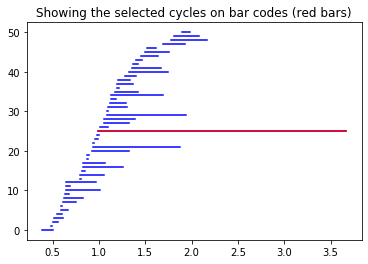

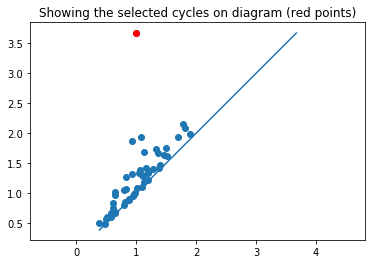

In [6]:
threshold = 1
bars = [bar for bar in dgms[1] if bar.death-bar.birth > threshold] #choosing cocycle that persist at least threshold=1.
cocycles = [cp.cocycle(bar.data) for bar in bars]
#plt is the matplotlib incarnation.

#Red highlight cocyles that persist more than threshold value on barcode, when more than one cocyles have persisted over threshold values, this plots the first one.
dionysus.plot.plot_bars(dgms[1], show=False)
plt.plot([[bar.birth,bar.death] for bar in dgms[1] if bar.death-bar.birth > threshold][0],[[x,x] for x,bar in enumerate(dgms[1]) if bar.death-bar.birth > threshold][0],'r')
plt.title('Showing the selected cycles on bar codes (red bars)')
plt.show()

#Red highlight ***ALL*** cocyles that persist more than threshold value on diagram.
dionysus.plot.plot_diagram(dgms[1], show=False)
Lt1 = [[point.birth,point.death] for point in dgms[1] if point.death-point.birth > threshold] 
for Lt3 in Lt1:
    #print(Lt3)
    plt.plot(Lt3[0],Lt3[1],'ro')
plt.title('Showing the selected cycles on diagram (red points)')
plt.show()


In [7]:
chosen_cocycle= cocycles[0]
chosen_bar= bars[0]

## Step 4 - First smoothing using Least Squares (Optional)

If it is computed the smoothed coefficients can be used as initial condition for the optimization code

In [8]:
vr_8 = dionysus.Filtration([s for s in vr if s.data <= max([bar.birth for bar in bars])])
coords = dionysus.smooth(vr_8, chosen_cocycle, prime)

### Visualization

In [9]:
np.shape(annulus.T)
annulus.T[1,:]

array([-3.67312146, -1.37451098, -3.05826372,  0.48873713,  2.35892311,
       -2.17771542,  1.36940685,  1.80185836,  0.70409856, -1.96707472,
       -2.23585118, -0.95008248,  3.29371294, -0.34403295, -3.84761921,
        1.42051272, -2.77180455,  1.55974964,  1.93420009, -1.04703595,
        1.54535866, -3.60881534, -2.88547645,  1.43178865, -1.48169108,
        3.30632454, -2.19826852,  0.62478487, -1.34096396,  1.64387073,
        1.79028863,  1.67195216,  2.86586025,  2.37386202, -1.57085332,
       -1.13563069,  2.82515809,  2.00831069, -1.31832037, -2.07797586,
        0.81300261, -0.52920814, -3.72967777, -1.89591003,  3.69583043,
        2.39202283,  0.53616103,  2.41538442,  2.09390966, -0.12945963,
        2.28337064, -1.9543261 ,  0.17813405,  1.60263529, -2.87567906,
       -1.99303913, -1.9908043 ,  1.91325815,  2.20271798,  0.08494396,
       -3.8989019 ,  3.79472091,  1.95324127,  3.48392092, -0.93486881,
        1.84718667, -3.18722767,  0.0979552 , -0.10991299,  3.47

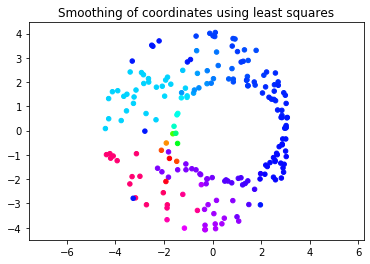

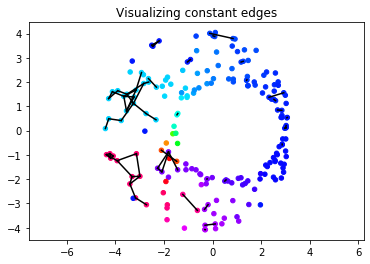

In [10]:
#plt.rcParams['lines.markersize'] = 150
scatter(annulus.T[0,:],annulus.T[1,:],s=20, c=coords, cmap="hsv")
plt.axis('equal')
plt.title('Smoothing of coordinates using least squares')
plt.show()

toll = 1e-5
p,val = (chosen_bar,coords)
edges_costant = []
thr = p.birth # i want to check all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(val[s[0]]-val[s[1]]) <= toll:
        edges_costant.append([annulus[s[0],:],annulus[s[1],:]])
edges_costant = np.array(edges_costant)
scatter(annulus.T[0,:],annulus.T[1,:],s=20, c=coords, cmap="hsv")
plot(edges_costant.T[0,:],edges_costant.T[1,:], c='k')
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()

## Step 5 - Second smoothing using a new cost function

In [11]:
import utils
l2_cocycle,f,bdry = utils.optimizer_inputs(vr, bars, chosen_cocycle, coords, prime)

In [12]:
#l2_cocycle.reshape(-1, 1)
l2_cocycle = l2_cocycle.reshape(-1, 1)
l2_cocycle.shape
f-bdry*l2_cocycle

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 4.62728814e-12],
       ...,
       [ 5.82303357e-02],
       [-2.97533516e-02],
       [-8.04065267e-01]])

In [13]:
##It does not seem to work to have double invokes here...
import scipy as scp
from scipy.optimize import minimize
#cost = lambda z: cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
#grad = lambda z: cost_functions.grad_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
def cost(z):
    import cost_functions
    return cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)

def grad(z):
    import cost_functions
    return cost_functions.grad_Lpnorm_mvj(z, F= f, B= bdry, p= 20)

#res = minimize(cost, l2_cocycle, method='L-BFGS-B', jac = grad)
res=scp.optimize.minimize(cost, l2_cocycle, method="Nelder-Mead") 
res

 final_simplex: (array([[ 0.71495163, -0.21490076,  0.26219679, ...,  0.14836786,
         0.00444708,  0.11313936],
       [ 0.70755065, -0.21520511,  0.25167291, ...,  0.16326735,
         0.00448208,  0.11123789],
       [ 0.71582606, -0.21317336,  0.26311858, ...,  0.15682781,
         0.00439735,  0.11104843],
       ...,
       [ 0.7046633 , -0.21439864,  0.25672088, ...,  0.15435457,
         0.00441328,  0.11169819],
       [ 0.71638148, -0.21925313,  0.25318754, ...,  0.15623423,
         0.00451634,  0.11240168],
       [ 0.70490182, -0.20981963,  0.26204754, ...,  0.15619847,
         0.00428757,  0.11087957]]), array([1.37706373, 1.37708225, 1.3771205 , 1.37715332, 1.37716463,
       1.37728239, 1.37728661, 1.37730112, 1.37734214, 1.37734587,
       1.37741803, 1.37744251, 1.37745204, 1.37748647, 1.37748739,
       1.37749222, 1.37750051, 1.37754715, 1.37759263, 1.37761073,
       1.37761733, 1.37767347, 1.37770231, 1.37777692, 1.37783978,
       1.37785145, 1.37787009, 1.3

In [18]:
import tensorflow as tf
#import tensorflow_probability as tfp
'''Following seems deprecated in newer version of tfp
#pip install --upgrade tensorflow-probability==0.70
#alternatively, we can use tensorflow to minimize the cost function without gradient information, here we can use multiple black-box functions like Adams
#For more: Check at https://www.tensorflow.org/probability/api_docs/python/tfp/math/minimize
x = tf.Variable(0.)
cost_fun = lambda: cost_functions.cost_Lpnorm_mvj(x, F= f, B= bdry, p= 20)
res_tfp=tfp.math.minimize(
        cost_fun,
        num_steps=1000,
        optimizer=tfp.optimizers.Adam(learning_rate=0.1)
        )
'''
#Following seems working, c.f. 
#https://stackoverflow.com/questions/55552715/tensorflow-2-0-minimize-a-simple-function
def cost(z):
    import cost_functions
    return cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
#type(bdry)
#scipy.sparse.csr.csr_matrix
B_mat = bdry.todense()
import tensorflow as tf
print(f.shape)
print((B_mat*l2_cocycle).shape)
z = tf.Variable(l2_cocycle, trainable=True)

#L1 in tensorflow language
cost_z = tf.reduce_sum( tf.abs(f - B_mat @ z) )
#L2 in tensorflow language
cost_z = tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),2 ) )
#Lp+alpha*Lq norm in tensorflow language
lp=1
lq=2
alpha=.5
cost_z = (1-alpha)*tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lp ) ), 1/lp) + alpha* tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lq ) ), 1/lq)

#Gradient Descedent Optimizer
opt_gd = tf.train.GradientDescentOptimizer(0.1).minimize(cost_z)
#Adams Optimizer
opt_adams = tf.train.AdamOptimizer(1e-4).minimize(cost_z)
#The latter is much better in terms of result

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):#How many iterations you want to run?
        #print(sess.run([x,loss]))
        sess.run(opt_adams)
    res_tf=sess.run([z,cost_z])
type(res_tf)
print(res_tf)
res_tf=res_tf[0]
res_tf

(7888, 1)
(7888, 1)
[array([[ 0.11583309],
       [ 0.12876784],
       [ 0.13742165],
       [-0.05721079],
       [-0.01727273],
       [ 0.0786415 ],
       [-0.05709237],
       [-0.00692939],
       [-0.05713997],
       [ 0.07865411],
       [ 0.07864679],
       [ 0.32294084],
       [-0.01727163],
       [-0.00689554],
       [ 0.078652  ],
       [-0.05710637],
       [ 0.14310418],
       [-0.00690504],
       [-0.01048052],
       [ 0.32243803],
       [-0.04987355],
       [ 0.07866034],
       [ 0.07865529],
       [-0.05692918],
       [-0.00687819],
       [-0.00692194],
       [ 0.15725742],
       [-0.00689204],
       [-0.00687162],
       [-0.05710125],
       [-0.05709784],
       [-0.05710709],
       [-0.05710052],
       [-0.00692131],
       [ 0.1121909 ],
       [ 0.32242834],
       [-0.00691983],
       [-0.00690888],
       [-0.00687895],
       [ 0.07865915],
       [-0.05710851],
       [-0.34633014],
       [ 0.07863872],
       [ 0.18487724],
       [-0.

array([[ 0.11583309],
       [ 0.12876784],
       [ 0.13742165],
       [-0.05721079],
       [-0.01727273],
       [ 0.0786415 ],
       [-0.05709237],
       [-0.00692939],
       [-0.05713997],
       [ 0.07865411],
       [ 0.07864679],
       [ 0.32294084],
       [-0.01727163],
       [-0.00689554],
       [ 0.078652  ],
       [-0.05710637],
       [ 0.14310418],
       [-0.00690504],
       [-0.01048052],
       [ 0.32243803],
       [-0.04987355],
       [ 0.07866034],
       [ 0.07865529],
       [-0.05692918],
       [-0.00687819],
       [-0.00692194],
       [ 0.15725742],
       [-0.00689204],
       [-0.00687162],
       [-0.05710125],
       [-0.05709784],
       [-0.05710709],
       [-0.05710052],
       [-0.00692131],
       [ 0.1121909 ],
       [ 0.32242834],
       [-0.00691983],
       [-0.00690888],
       [-0.00687895],
       [ 0.07865915],
       [-0.05710851],
       [-0.34633014],
       [ 0.07863872],
       [ 0.18487724],
       [-0.04988328],
       [-0

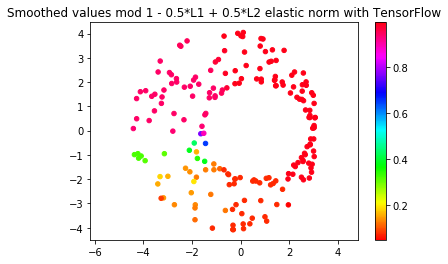

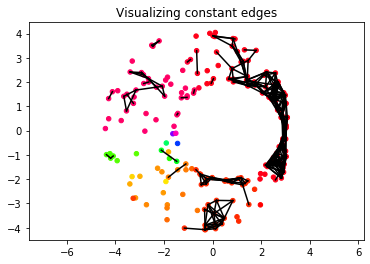

In [19]:
color = np.mod(res_tf.T[0,:],1)
scatter(annulus.T[0,:],annulus.T[1,:],s=20, c=color, cmap="hsv")
#scatter(*annulus.T, c= color, cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('Smoothed values mod 1 - {}*L{} + {}*L{} elastic norm with TensorFlow'.format(1-alpha,lp,alpha,lq))
plt.show()
toll = 1e-5
edges_constant = []
thr = chosen_bar.birth # i want to check constant edges in all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(color[s[0]]-color[s[1]]) <= toll:
        edges_constant.append([annulus[s[0],:],annulus[s[1],:]])
edges_constant = np.array(edges_constant)        
#scatter(*annulus.T, c=color, cmap="hsv", alpha=.5)
scatter(annulus.T[0,:],annulus.T[1,:],s=20, c=color, cmap="hsv")
#plot(*edges_constant.T, c='k')
plot(edges_constant.T[0,:],edges_constant.T[1,:], c='k')
edges_constant.shape
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()